In [1]:
# import libraries needed
import pandas as pd  # For handling structured data (DataFrames)
import numpy as np  # For numerical calculations and handling missing values
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Define HS codes of interest
hs_codes = ['854149', '854159', '854160', '854231', '854232', '854239']

# Setup Paths
global_file = r'C:/Users/User/OneDrive/Documents/Chow_research/Taiwan_6_HScodes/TaiwanGlobalExport/taiwan_exp_6products.xls'
country_file = r'C:/Users/User/OneDrive/Documents/Chow_research/Taiwan_6_HScodes/TaiwanCountryExport/taiwan_country_exp_6product.xls'

def fileprep(globalexp_df):
    """
    Clean and prepare export data by grouping total monthly value by HS code.

    Parameters:
    ----------
    globalexp_df : DataFrame
        Raw dataframe with 'Time', 'Commodity Code', and 'Value(USD$ 1,000)'

    Returns:
    -------
    DataFrame with columns: Time (datetime), HS_Code (string), Value (float)
    """
    # Clean Time (remove text in parentheses, if any)
    globalexp_df['Time'] = globalexp_df['Time'].astype(str).str.split("(").str[0]
    globalexp_df['Time'] = pd.to_datetime(globalexp_df['Time'], format="%Y/%m", errors='coerce')

    # Clean HS Code and Value
    globalexp_df['Commodity Code'] = globalexp_df['Commodity Code'].astype(str).str.strip()
    globalexp_df['Value(USD$ 1,000)'] = pd.to_numeric(globalexp_df['Value(USD$ 1,000)'], errors='coerce')

    # Drop invalid rows
    globalexp_df.dropna(subset=['Time', 'Commodity Code', 'Value(USD$ 1,000)'], inplace=True)

    # ✅ Group by month + HS code, and sum the value
    result = globalexp_df.groupby([
        pd.Grouper(key='Time', freq='ME'),
        'Commodity Code'
    ], as_index=False)['Value(USD$ 1,000)'].sum()

    # Rename columns for clarity
    result.rename(columns={'Commodity Code': 'HS_Code', 'Value(USD$ 1,000)': 'Global Value'}, inplace=True)
    return result

# Load raw data
df_raw = pd.read_excel('C:/Users/User/OneDrive/Documents/Chow_research/Taiwan_6_HScodes/TaiwanGlobalExport/taiwan_exp_6products.xls', engine='xlrd')

# Process it
df_monthly = fileprep(df_raw)

print(df_monthly)

def fileprep_country(country_file, hs_codes):
    """
    Loads country-level export data from .xls file, filters by HS codes,
    merges Hong Kong into China, and groups by Time + HS Code + Country.
    """
    df = pd.read_excel(country_file, engine='xlrd')

    # Clean Time
    df['Time'] = df['Time'].astype(str).str.split("(").str[0]
    df['Time'] = pd.to_datetime(df['Time'], format="%Y/%m", errors='coerce')

    # Keep only relevant columns
    df = df[['Time', 'Commodity Code', 'Country(Area)', 'Value(USD$ 1,000)']]

    # Rename columns
    df.columns = ['Time', 'HS_Code', 'Country', 'Country_Value']

    # Filter by HS codes
    df['HS_Code'] = df['HS_Code'].astype(str).str.strip()
    df = df[df['HS_Code'].isin(hs_codes)]

    # Combine Hong Kong into China
    df['Country'] = df['Country'].replace({
        'Hong Kong': 'China'})

    # Regroup to combine values after merging Hong Kong into China
    df = df.groupby(['Time', 'HS_Code', 'Country'], as_index=False)['Country_Value'].sum()

    return df

# Load raw data
country_file = r'C:/Users/User/OneDrive/Documents/Chow_research/Taiwan_6_HScodes/TaiwanCountryExport/taiwan_country_exp_6product.xls'

# Pass it to the function
country_df = fileprep_country(country_file, hs_codes)
print(country_df.head(50))

# Ensure Time is in monthly period format for both dataframes
country_df['Time'] = pd.to_datetime(country_df['Time']).dt.to_period('M')
df_monthly['Time'] = pd.to_datetime(df_monthly['Time']).dt.to_period('M')

# Merge global and country data on Time + HS_Code
merged_df = pd.merge(
    country_df,
    df_monthly,
    how='left',
    on=['Time', 'HS_Code']
)

# Compute Market Share (%)
merged_df['Market_Share (%)'] = (merged_df['Country_Value'] / merged_df['Global Value']) * 100

# Sort and preview
merged_df.sort_values(['Time', 'HS_Code', 'Market_Share (%)'], ascending=[True, True, False], inplace=True)
print(merged_df[['Time', 'HS_Code', 'Country', 'Country_Value', 'Global Value', 'Market_Share (%)']].head(10))

output_path = r'C:/Users/User/OneDrive/Documents/Chow_research/Taiwan_6_HScodes/merged_marketshare.xlsx'

# Convert Periods to string for Excel compatibility
merged_df['Time'] = merged_df['Time'].astype(str)

# Export to Excel
merged_df.to_excel(output_path, index=False)


# Output folder for separate files
output_folder = r'C:/Users/User/OneDrive/Documents/Chow_research/Taiwan_6_HScodes/individual_exports'

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# Loop through each HS code and export its data
for code in hs_codes:
    hs_df = merged_df[merged_df['HS_Code'] == code]
    
    # Construct output file path
    file_name = f"marketshare_HS{code}.xlsx"
    file_path = os.path.join(output_folder, file_name)
    
    # Export
    hs_df.to_excel(file_path, index=False)
    print(f"✅ Exported: {file_path}")




print(f"Excel file written to:\n{output_path}")

          Time HS_Code  Global Value
0   2016-01-31  854160         46818
1   2016-01-31  854231        130914
2   2016-01-31  854232        609668
3   2016-01-31  854239       4941181
4   2016-02-29  854160         29164
..         ...     ...           ...
477 2025-02-28  854159          2588
478 2025-02-28  854160         58973
479 2025-02-28  854231       1892249
480 2025-02-28  854232       2137610
481 2025-02-28  854239       9431968

[482 rows x 3 columns]
         Time HS_Code             Country  Country_Value
0  2016-01-01  854160               China          37656
1  2016-01-01  854160               Japan            444
2  2016-01-01  854160  Korea, Republic of            589
3  2016-01-01  854160            Malaysia           1082
4  2016-01-01  854160         Netherlands             16
5  2016-01-01  854160           Singapore            885
6  2016-01-01  854160            Thailand            803
7  2016-01-01  854160       United States           2216
8  2016-01-01  8541

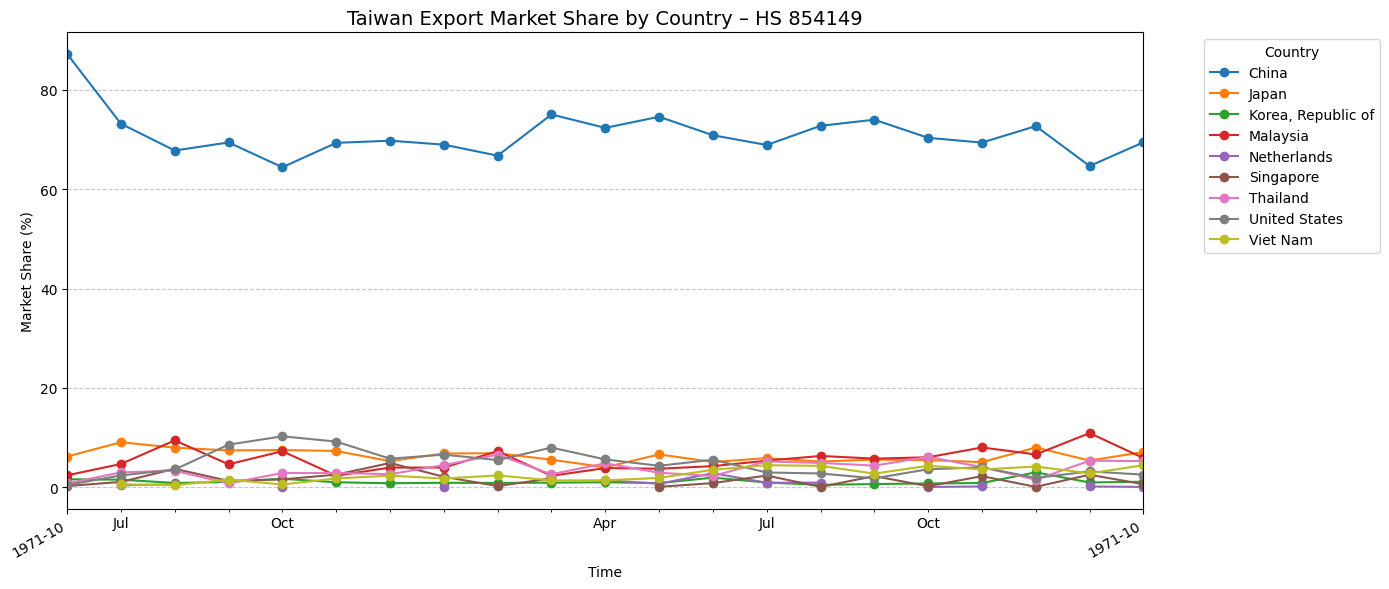

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Restore Time back to datetime format for plotting
merged_df['Time'] = pd.to_datetime(merged_df['Time'])

# Filter for a specific HS code
filtered = merged_df[merged_df['HS_Code'] == '854149'].copy()

# Pivot the data: Time = rows, Country = columns, Market Share = values
pivot = filtered.pivot(index='Time', columns='Country', values='Market_Share (%)')

# Create full timeline index
full_index = pd.date_range(start=filtered['Time'].min(), end=filtered['Time'].max(), freq='MS')
pivot = pivot.reindex(full_index)

# Plot the time series
fig, ax = plt.subplots(figsize=(14, 6))
pivot.plot(ax=ax, marker='o')

ax.set_title("Taiwan Export Market Share by Country – HS 854149", fontsize=14)
ax.set_xlabel("Time")
ax.set_ylabel("Market Share (%)")
ax.grid(True, linestyle='--', alpha=0.7)

# X-axis formatting
ax.set_xlim([full_index.min(), full_index.max()])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_market_share_by_hscode(merged_df, hs_code):
    """
    Plot Taiwan export market share over time by country for a specific HS code.

    Parameters:
    -----------
    merged_df : pd.DataFrame
        The full merged DataFrame with columns: Time, HS_Code, Country, Market_Share (%)
    hs_code : str
        HS code to filter and visualize (e.g., '854149')
    """

    # Filter and prepare data
    df = merged_df[merged_df['HS_Code'] == hs_code].copy()
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

    # Pivot: rows = Time, columns = Country, values = Market Share
    pivot = df.pivot(index='Time', columns='Country', values='Market_Share (%)')

    # Create full monthly timeline for continuity
    start = df['Time'].min().replace(day=1)
    end = df['Time'].max().replace(day=1)
    full_index = pd.date_range(start=start, end=end, freq='MS')
    pivot = pivot.reindex(full_index)

    # Plot
    fig, ax = plt.subplots(figsize=(20, 10))
    for country in pivot.columns:
        ax.plot(pivot.index, pivot[country], marker='o', label=country)

    # Format axes
    ax.set_title(f"Taiwan Export Market Share by Country – HS {hs_code}", fontsize=14)
    ax.set_xlabel("Time")
    ax.set_ylabel("Market Share (%)")
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlim([start, end])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.get_xticklabels(), rotation=90)  # 🔁 rotate x-axis labels

    # Legend
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


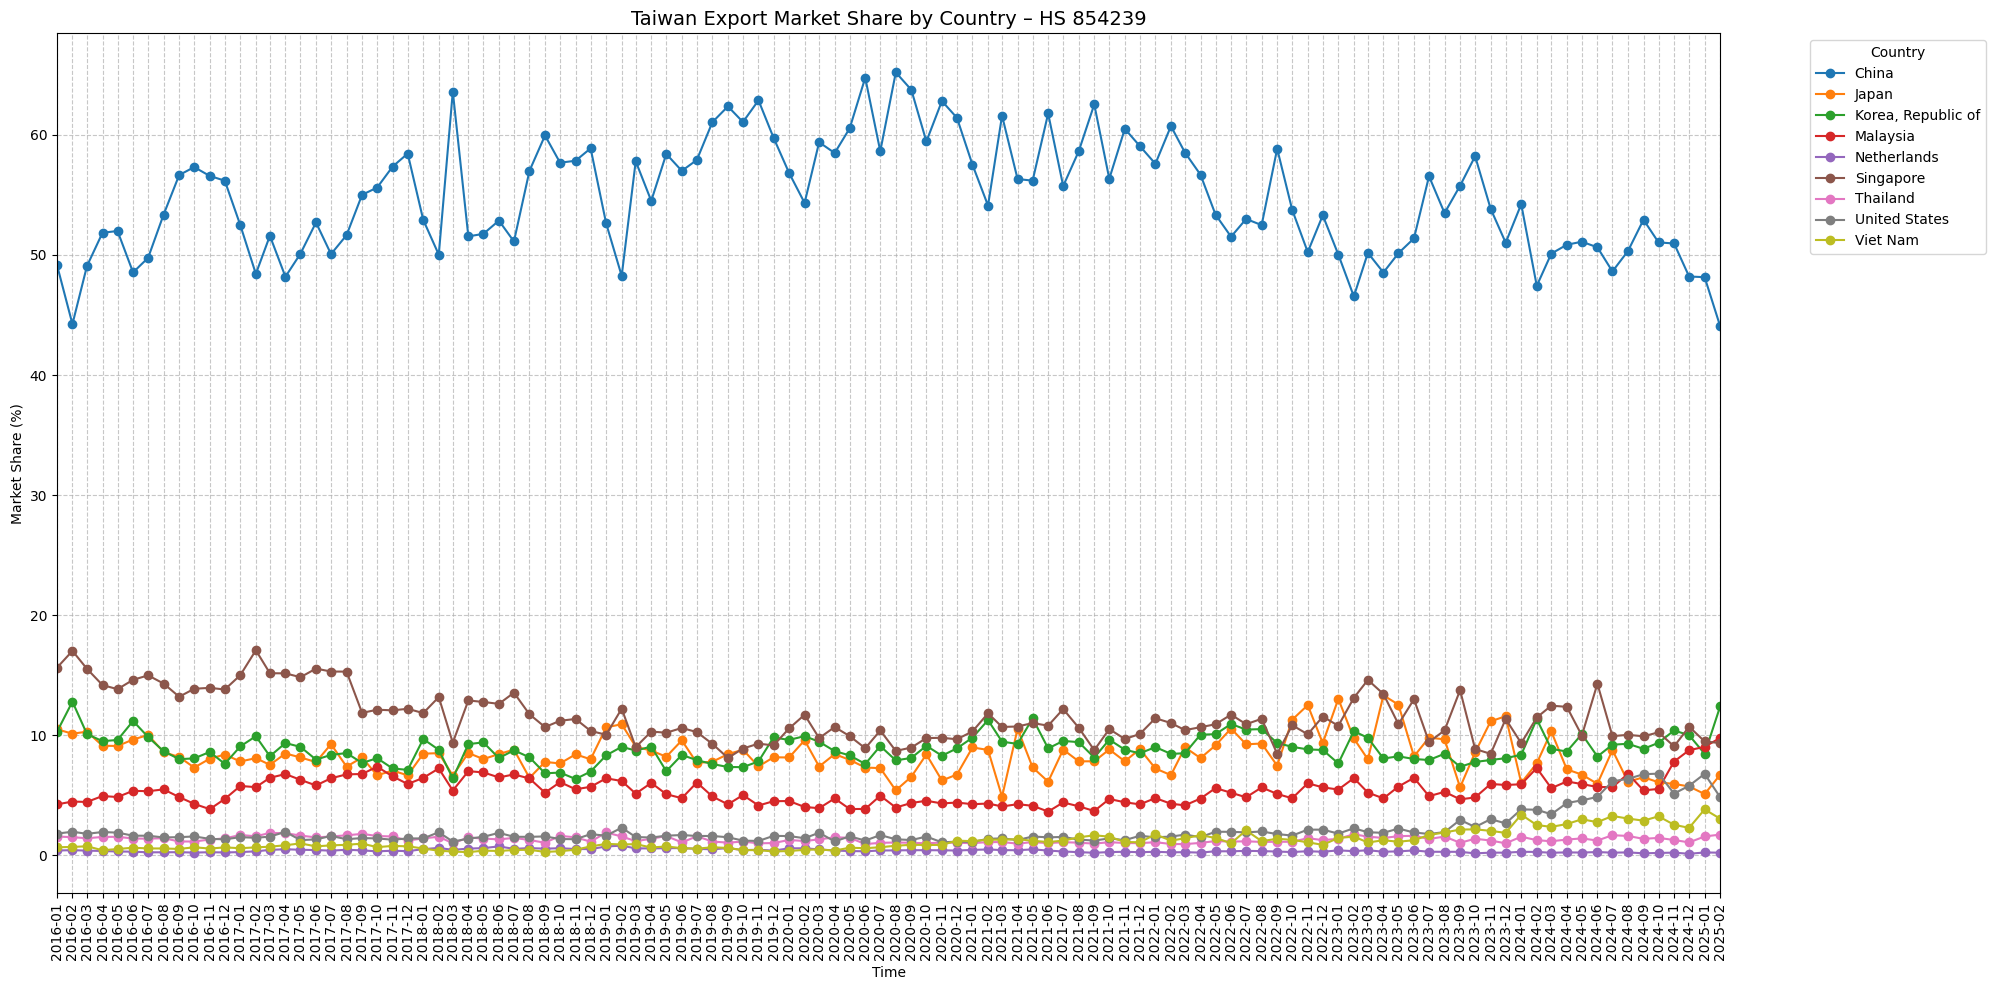

In [29]:
#   '854149', '854159', '854160', '854231', '854232', '854239'
plot_market_share_by_hscode(merged_df, '854239')